In [3]:
# default_exp geometry.meshed_geometry

# Create meshed geometry

> API details.

In [4]:
#hide
from nbdev.showdoc import *
import matplotlib
import matplotlib.pyplot as plt

In [5]:
#export
import os

In [6]:
#hide
import sys, subprocess

sys.path.append(os.path.join(os.getcwd(), '..'))

In [7]:
#export
import numpy as np
import pygmsh
import meshio

from accelerate_simulations.geometry import AbstractGeometry

In [27]:
#hide
box_size = (100, 100)
circle_radius = 5
n_circles = 10

In [28]:
#hide
abstract_geometry = AbstractGeometry(n_circles, circle_radius, box_size, 42)
abstract_geometry.n_circles

10

In [82]:
#export
def make_msh(output_path, abstract_geometry: AbstractGeometry, cl_coarse, cl_fine, path_to_tethex, verbose=False):
    circle_centers, circle_radius, box_corner_coords = abstract_geometry.get_geom_info()

    with pygmsh.geo.Geometry() as geom:

        point1 = geom.add_point([box_corner_coords[0][0], box_corner_coords[0][1], 0], cl_coarse)
        point2 = geom.add_point([box_corner_coords[1][0], box_corner_coords[1][1], 0], cl_coarse)
        point3 = geom.add_point([box_corner_coords[2][0], box_corner_coords[2][1], 0], cl_coarse)
        point4 = geom.add_point([box_corner_coords[3][0], box_corner_coords[3][1], 0], cl_coarse)

        line1 = geom.add_line(point1, point2)
        line2 = geom.add_line(point2, point3)
        line3 = geom.add_line(point3, point4)
        line4 = geom.add_line(point4, point1)

        circle_loops = []
        circle_surfaces = []
        for idx, circle_center in enumerate(circle_centers):
            pointc = geom.add_point([circle_center[0], circle_center[1], 0], cl_fine)
            points = geom.add_point([circle_center[0]+circle_radius, circle_center[1], 0], cl_fine)
            circle = geom.add_circle_arc(points, pointc, points)
            
            circle_loop = geom.add_curve_loop([circle])
            surface = geom.add_plane_surface(circle_loop)
            
            circle_loops.append(circle_loop)
            circle_surfaces.append(surface)

        line_loop1 = geom.add_curve_loop([line1, line2, line3, line4])
        surface1 = geom.add_plane_surface(line_loop1, circle_loops)

        geom.add_physical(surface1, label="2")
        geom.add_physical(circle_surfaces, label="1")
        
        geom.add_physical(line1, label="4")
        geom.add_physical(line2, label="5")
        geom.add_physical(line3, label="6")
        geom.add_physical(line4, label="3")

        if verbose: print('[INFO] making triangular mesh ...')    
        mesh = geom.generate_mesh(dim=2, verbose=verbose)
       
    if verbose: print('[INFO] writing msh file ...')
    mesh.write(output_path, file_format="gmsh22", binary=False)

    if verbose: print('[INFO] converting tringular to quad mesh ...')
    os.system(f'{path_to_tethex} {output_path} {output_path.replace(".msh", "_hex.msh")} {int(verbose)}')

    return mesh

In [83]:
mesh = make_msh('../../data/test.msh', abstract_geometry, cl_coarse=5, cl_fine=2, verbose=True, path_to_tethex='~/dev/tethex/build/tethex')

[INFO] making triangular mesh ...
[INFO] writing msh file ...
[INFO] converting tringular to quad mesh ...


In [62]:
from scipy.spatial import Delaunay

mesh_delaunay = Delaunay(mesh.points[:, :2])
mesh_delaunay.simplices = np.array(mesh.cells[1].data)

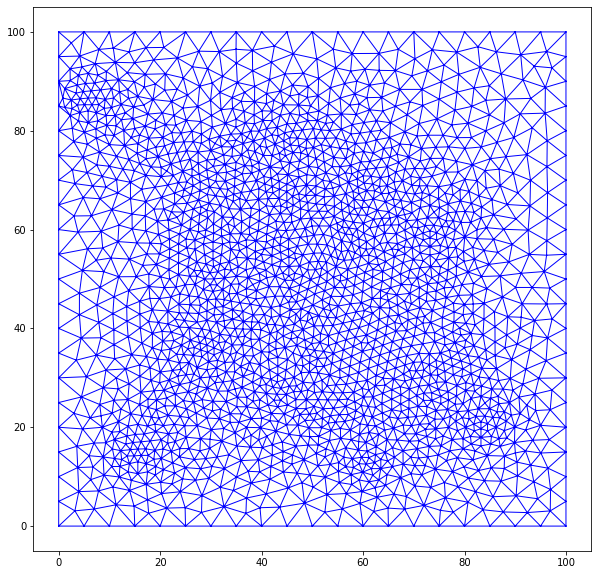

In [63]:
plt.figure(figsize=(10, 10))
triangulation = matplotlib.tri.Triangulation(mesh_delaunay.points[:, 0], mesh_delaunay.points[:, 1], mesh_delaunay.simplices)
plt.triplot(triangulation, color='b', linewidth=1, alpha=1.0)
